<br/>
<span style="font-size: 4em;">MSP Population Synthesis Pipeline</span>
<br/><br/>
<span style="font-size: 4em;">for MSIP 2020</span>

Don't actually run this notebook. This is just if you care to see exactly what I did.

In [1]:
import cPickle
import os
import tarfile
import pandas as pd
from glob import glob
from copy import deepcopy
from itertools import product
from operator import attrgetter, itemgetter
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PTAOptimizer import timing_precision
from PTAOptimizer.timed import Timed
from PTAOptimizer import mkasc
from psrpoppy.populate import rednoise_sc10

# Add Red Noise into Model
Compute $A_\mathrm{red}$ and $\gamma_\mathrm{red}$ for each pulsar in the population.

In [2]:
# read in psrpoppy population model
# This is old model based only on Parkes MB
with open('../models/MSPpop.model', 'rb') as popfile:
    pop = cPickle.load(popfile)

In [3]:
len(pop.population)

38475

In [4]:
# pop.rn_lnC2, pop.rn_alpha, pop.rn_beta, pop.rn_gamma, pop.rn_delta = (1.6, -1.4, 1.1, 2.0, 1.6)
# for p in pop.population:
#     p.rn_amp, p.rn_index = rednoise_sc10(p, lnC2=1.6,
#                                          alpha=-1.4,
#                                          beta=1.1,
#                                          gamma=2.0,
#                                          delta=1.6)

# Determine Pulsars to Exclude
Remove pulsars whose RMS white noise $\left(\sqrt{\sigma_\mathrm{RN}^2 + \sigma_\mathrm{j}^2}\right)$ resemble pulsars in the real NANOGrav dataset.

In [5]:
# AO L-S frequency range
Lband_nus = np.linspace(1.44 - .618 / 2, 1.44 + .618 / 2, 55 + 1)[:-1]
# S-high
Shi_nus = np.linspace(2.227 - .354 / 2, 2.227 + .354 / 2, 30 + 1)[:-1]
# S-low
Slo_nus = np.linspace(1.79 - .180 / 2, 1.79 + .180 / 2, 15 + 1)[:-1]
aoLS_nus = np.sort(np.concatenate([Lband_nus, Slo_nus, Shi_nus]))

# AO 430-L frequency range
nus_ao430 = np.linspace(.432 - .02 / 2, .432 + .02 / 2, 10 + 1)[:-1]
nus_aoL = np.linspace(1.44 - .58 / 2, 1.44 + .58 / 2, 90 + 1)[:-1]
ao430L_nus = np.concatenate([nus_ao430, nus_aoL])

# GB 800-1200 frequency range
nus_gb800 = np.linspace(.820 - .200 / 2, .820 + .200 / 2, 20 + 1)[:-1]
nus_gb1_2 = np.linspace(1.510 - .800 / 2, 1.510 + .800 / 2, 80 + 1)[:-1]
gbt80012_nus = np.concatenate([nus_gb800, nus_gb1_2])

In [6]:
# Time population with each configuration of AO and GBT frequency
# It's 30 min/frequency right?
gbt80012_pta = timing_precision.run_timing(pop, gbt80012_nus, 
                                             rxspecfile='GBT_Rcvr_800-Rcvr_1_2_test.txt',
                                             t_int=1800., dec_lim=(90.0, -46.0)) 
ao430L_pta = timing_precision.run_timing(pop, ao430L_nus, 
                                            rxspecfile='AO_430_Lwide_test.txt',
                                            t_int=1800., dec_lim=(39.0, 0.0))
aoLS_pta = timing_precision.run_timing(pop, aoLS_nus, 
                                        rxspecfile='AO_Lwide_Swide.txt',
                                        t_int=1800., dec_lim=(39.0, 0.0))

In [7]:
# Pick best frequency range for each MSP at Arecibo
aobest_list = timing_precision.best_timed([ao430L_pta, aoLS_pta])
print('{} MSPs in sim AO list'.format(len(aobest_list)))
# Exclude AO sky from GBT
gbt_list = [p for p in gbt80012_pta.population if (p.dec >= 39. or p.dec <= 0.) and p.sigma_toa > 0.]
print('{} MSPs in sim GBT list'.format(len(gbt_list)))

1812 MSPs in sim AO list
9578 MSPs in sim GBT list


In [8]:
# Read in NG RMSs and separate by telescope
df = pd.read_csv('NG_RMS.csv')
ngrms_gbt = list(np.array(df.RMS)[np.where(df.Observatory == 'GBT')])
ngrms_ao = list(np.array(df.RMS)[np.where(df.Observatory == 'AO')])

In [9]:
# Remove simulated MSPs similar to NG MSPs from GBT PTA
gbt_excl = []
for i in range(len(ngrms_gbt)):
    closest = sorted(product(gbt_list, ngrms_gbt),
                       key=lambda t: abs( np.sqrt(t[0].sigma_rn ** 2 + t[0].sigmaj(1800.)**2) - t[1]))[0]
    gbt_list.remove(closest[0])
    gbt_excl.append(closest[0])
    ngrms_gbt.remove(closest[1])
print('{} MSPs in sim GBT list, {} MSPs in NG RMS list'.format(len(gbt_list), len(ngrms_gbt)))

9544 MSPs in sim GBT list, 0 MSPs in NG RMS list


In [10]:
# get location of excluded pulsars in GBT pta
gbt_exclidx = [gbt80012_pta.population.index(p) for p in gbt_excl]

In [11]:
# Remove simulated MSPs similar to NG MSPs from AO PTA
ao_excl = []
for i in range(len(ngrms_ao)):
    closest = sorted(product(aobest_list, ngrms_ao),
                       key=lambda t: abs( np.sqrt(t[0].sigma_rn ** 2 + t[0].sigmaj(1800.)**2) - t[1]))[0]
    aobest_list.remove(closest[0])
    ao_excl.append(closest[0])
    ngrms_ao.remove(closest[1])
print('{} MSPs in sim AO list, {} MSPs in NG RMS list'.format(len(aobest_list), len(ngrms_ao)))

1777 MSPs in sim AO list, 0 MSPs in NG RMS list


In [12]:
# get location of excluded pulsars in AO pta
ao_exclidx = []
for p in ao_excl:
    try:
        ao_exclidx.append(ao430L_pta.population.index(p))
    except ValueError:
        ao_exclidx.append(aoLS_pta.population.index(p))

In [13]:
# Remove excluded pulsars from population and save model to file
all_exclidx = set(ao_exclidx + gbt_exclidx)
incl_pop = deepcopy(pop)
incl_pop.population = [p for i, p in enumerate(pop.population) if i not in all_exclidx]
with open('models/incl_MSPpop.model', 'wb') as inclf:
    cPickle.dump(incl_pop, inclf)

In [14]:
# Save excluded pulsars (FOpPulsar's) to a separate model file
excl_pop = deepcopy(pop)
excl_pop.population = ao_excl + gbt_excl
with open('models/excl_MSPpop.model', 'wb') as exclf:
    cPickle.dump(excl_pop, exclf)

# Time Populations with Respective Instruments
Run included and excluded pulsars through various telescope configurations and compute $\sigma$s. Two-band computations should use $t_\mathrm{int} = 30\mathrm{\ min/epoch}$ and single, wide-band systems should use $t_\mathrm{int} = 1\mathrm{\ hr/epoch}$.

In [15]:
# set up frequency ranges

# AO L-S frequency range
Lband_nus = np.linspace(1.44 - .618 / 2, 1.44 + .618 / 2, 55 + 1)[:-1]
# S-high
Shi_nus = np.linspace(2.227 - .354 / 2, 2.227 + .354 / 2, 30 + 1)[:-1]
# S-low
Slo_nus = np.linspace(1.79 - .180 / 2, 1.79 + .180 / 2, 15 + 1)[:-1]
aoLS_nus = np.sort(np.concatenate([Lband_nus, Slo_nus, Shi_nus]))

# AO 430-L frequency range
nus_ao430 = np.linspace(.432 - .02 / 2, .432 + .02 / 2, 10 + 1)[:-1]
nus_aoL = np.linspace(1.44 - .58 / 2, 1.44 + .58 / 2, 90 + 1)[:-1]
ao430L_nus = np.concatenate([nus_ao430, nus_aoL])

# GB 800-1200 frequency range
nus_gb800 = np.linspace(.820 - .200 / 2, .820 + .200 / 2, 20 + 1)[:-1]
nus_gb1_2 = np.linspace(1.510 - .800 / 2, 1.510 + .800 / 2, 80 + 1)[:-1]
gbt80012_nus = np.concatenate([nus_gb800, nus_gb1_2])

# GBT UWB 
gbuwb_ctrfreq = 2.35 #GHz
gbuwb_bw = 3.3 # GHz
gbuwb_nus = np.linspace(gbuwb_ctrfreq - gbuwb_bw / 2,
                        gbuwb_ctrfreq + gbuwb_bw / 2,
                        100 + 1)[:-1]

# AO UWB
aouwb_ctrf = 2.368
aouwb_bw = 3.328
aouwb_nus = np.linspace(aouwb_ctrf - aouwb_bw / 2, aouwb_ctrf + aouwb_bw / 2, 100 + 1)[:-1]

# DSA 0.7-2 GHz
dsa072_nus = np.linspace(1.35 - 1.3 / 2, 1.35 + 1.3 / 2, 100 + 1)[:-1]

# VLA L & S 
vlaL_nus = np.linspace(1.5 - 1. / 2., 1.5 + 1. / 2., 50 + 1)[:-1]
vlaS_nus = np.linspace(3. - 2. / 2., 3. + 2. / 2., 50 + 1)[:-1]
vlaLS_nus = np.concatenate([vlaL_nus, vlaS_nus])

# ngVLA Band 1 and 2
ngvB1_nus = np.linspace(2.35 - 2.3 / 2, 2.35 + 2.3 / 2, 50 + 1)[:-1]
ngvB2_nus = np.linspace(7.9 - 8.8 / 2, 7.9 + 8.8 / 2, 50 + 1)[:-1]
ngvlaB12_nus = np.concatenate([ngvB1_nus, ngvB2_nus])

In [16]:
# Run included and excluded ~real MSPs through timing campaigns
for cl in ['excl', 'incl']:
    with open('models/{}_MSPpop.model'.format(cl), 'rb') as popfile:                     
        clpop = cPickle.load(popfile)  

    # Arecibo 430 & Lwide PTA
    ao430L_pta = timing_precision.run_timing(clpop, ao430L_nus,  
                                             rxspecfile='AO_430_Lwide_test.txt',
                                             t_int=1800.,
                                             dec_lim=(39.0, 0.0))
    with open('models/{}_AO_430_Lwide_V3.pta.model'.format(cl), 'wb') as aooutf:
        cPickle.dump(ao430L_pta, aooutf)
        
    # Arecibo L & S-band
    aoLS_pta = timing_precision.run_timing(clpop, aoLS_nus,  
                                             rxspecfile='AO_Lwide_Swide.txt',
                                             t_int=1800.,
                                             dec_lim=(39., 0.))
    with open('models/{}_AO_Lwide_Swide_V3.pta.model'.format(cl), 'wb') as aooutf:
        cPickle.dump(aoLS_pta, aooutf)

    # GBT PTA
    gbt_pta = timing_precision.run_timing(clpop, gbt80012_nus, 
                                          rxspecfile='GBT_Rcvr_800-Rcvr_1_2_test.txt',
                                          t_int=1800.,
                                          dec_lim=(90.0, -46.0))
    with open('models/{}_GBT_Rcvr800_Rcvr12_V2.pta.model'.format(cl), 'wb') as gboutf:        
        cPickle.dump(gbt_pta, gboutf)

    # GBT UWB (double integration time for wide-band)
    gbuwbspecfile = 'Corr_Efficiency_Dielectric_Loaded_Dec6_lowfmod.txt'
    gbtuwb_pta = timing_precision.run_timing(clpop, gbuwb_nus, 
                                             rxspecfile=gbuwbspecfile,
                                             t_int=3600., dec_lim=(90, -46))
    with open('models/{}_GBT_UWB_V3.pta.model'.format(cl), 'wb') as guwboutf:   
         cPickle.dump(gbtuwb_pta, guwboutf)

    # AO UWB
    aouwb_pta = timing_precision.run_timing(clpop, aouwb_nus, 
                                            rxspecfile='AO_UWB.txt',
                                            t_int=3600., dec_lim=(39., 0.))
    with open('models/{}_AO_UWB_V1.pta.model'.format(cl), 'wb') as auwboutf:   
         cPickle.dump(aouwb_pta, auwboutf)

    # DSA 0.7-2 GHz full array
    dsa072_pta = timing_precision.run_timing(clpop, dsa072_nus,
                                             Trx=20.,
                                             Gain=10.,
                                             eps=0.01,
                                             t_int=3600.,
                                             dec_lim=(90.0, -44.0))
    with open('models/{}_dsa2k_07-2_V3.pta.model'.format(cl), 'wb') as dsa072outf:
        cPickle.dump(dsa072_pta, dsa072outf)

    # DSA 0.7-2, 1/2 Aeff
    dsa072half_pta = timing_precision.run_timing(clpop, dsa072_nus,
                                                 Trx=20.,
                                                 Gain=5.,
                                                 eps=0.01, t_int=3600.,
                                                 dec_lim=(90.0, -44.0))
    with open('models/{}_dsa2k_07-2_halfAeff_V3.pta.model'.format(cl), 'wb') as dsahalfoutf:
        cPickle.dump(dsa072half_pta, dsahalfoutf)

    # DSA 0.7-2, 1/4 Aeff
    dsa072quart_pta = timing_precision.run_timing(clpop, dsa072_nus,
                                                 Trx=20.,
                                                 Gain=2.5,
                                                 eps=0.01, t_int=3600.,
                                                 dec_lim=(90.0, -44.0))
    with open('models/{}_dsa2k_07-2_quartAeff_V3.pta.model'.format(cl), 'wb') as dsaqtoutf:
        cPickle.dump(dsa072quart_pta, dsaqtoutf)

    # VLA L-S band
    vlaLS_pta = timing_precision.run_timing(clpop, vlaLS_nus,
                                            rxspecfile='VLA_L-SBand.txt',
                                            t_int=1800.,
                                            dec_lim=(90.0, -44.0))
    with open('models/{}_VLA_LBand-SBand_V2.pta.model'.format(cl), 'wb') as vlaLSf:
        cPickle.dump(vlaLS_pta, vlaLSf)


    # ngVLA Band1-Band2 20% area
    ngvla_pta = timing_precision.run_timing(clpop, ngvlaB12_nus,
                                            rxspecfile='ngVLA_20pct.txt',
                                            t_int=1800.,
                                            dec_lim=(90.0, -44.0))
    with open('models/{}_ngVLA_Band1-2_V3.pta.model'.format(cl), 'wb') as ngvlaf:
        cPickle.dump(ngvla_pta, ngvlaf)

# Check that RMSs Make Sense

In [20]:
gb_stoas = np.array([p.sigma_toa for p in gbt_pta.population if p.sigma_toa > 0.])
gbtuwb_stoas = np.array([p.sigma_toa for p in gbtuwb_pta.population if p.sigma_toa > 0.])
gbratio = gb_stoas / gbtuwb_stoas

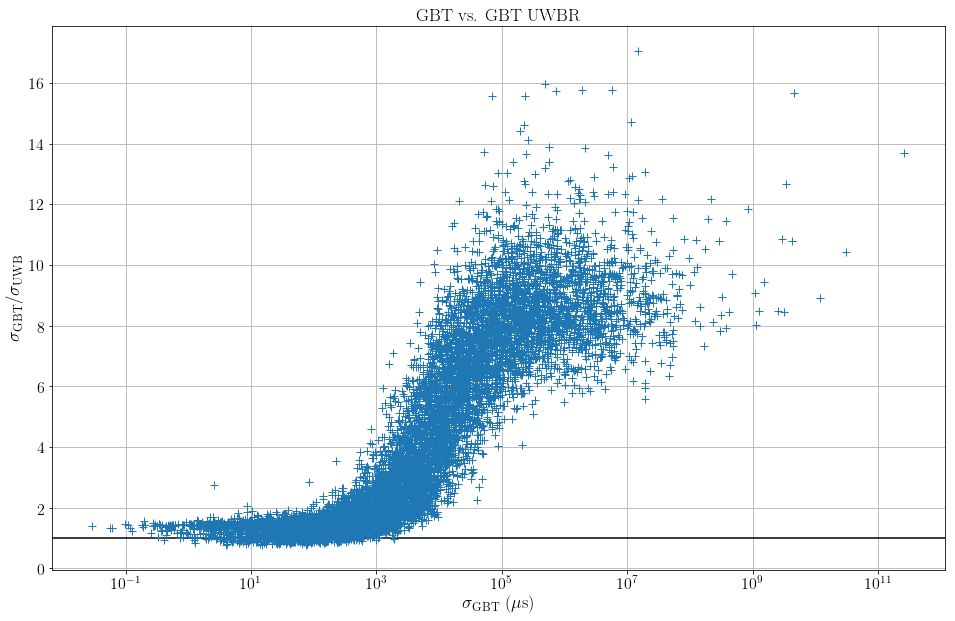

In [48]:
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'lines.markersize': 8})
ax.set_xlabel(r'$\sigma_\mathrm{GBT}\ (\mathrm{\mu s})$')
ax.set_ylabel(r'$\sigma_\mathrm{GBT}$/$\sigma_\mathrm{UWB}$')
ax.set_title(r'GBT vs. GBT UWBR')
ax.set_xscale('log')
#ax.set_xlim(1e-2, 100)
#ax.set_ylim(0, 2)
ax.axhline(1., color='black')
ax.plot(gb_stoas, gbratio, '+')
ax.grid()
plt.show();

In [42]:
# get AO RMSs to compare - not the best way
aouwb_stoas = []
ao_sigs = []
for p_ao430L, p_aoLS, p_aouwb in zip(ao430L_pta.population,
                                     aoLS_pta.population,
                                     aouwb_pta.population):
    if p_aouwb.sigma_toa > 0.:
        best1 = min([p_ao430L, p_aoLS], key=attrgetter('sigma_toa'))
        if p_aouwb.jname() != best1.jname():
            print('Not the same pulsar!!!')
        ao_sigs.append(best1.sigma_toa)
        aouwb_stoas.append(p_aouwb.sigma_toa)

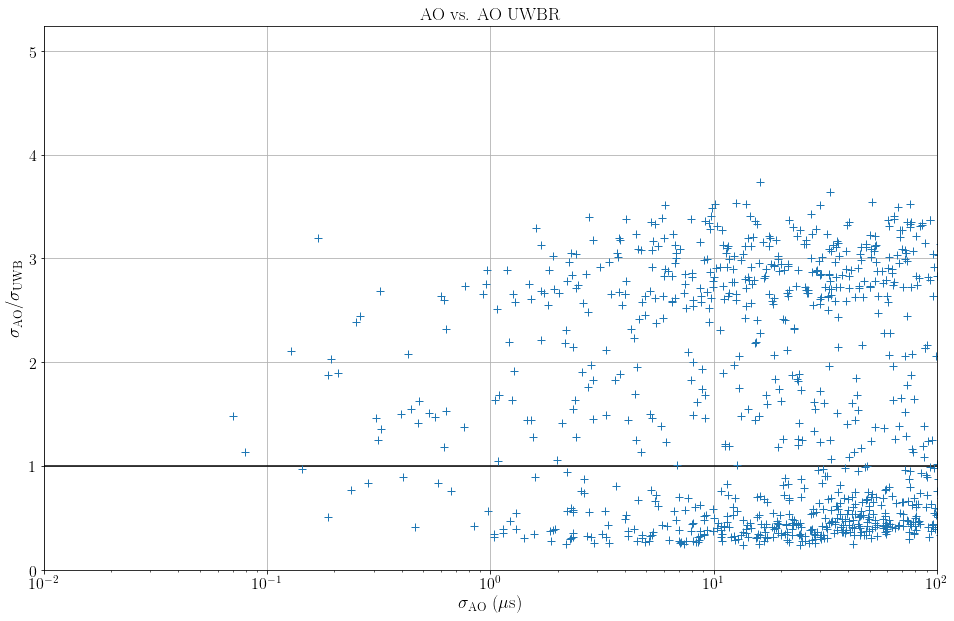

In [57]:
ao_stoas = np.array(ao_sigs)
aoratio = np.array(ao_stoas) / np.array(aouwb_stoas)
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'lines.markersize': 8})
ax.set_xlabel(r'$\sigma_\mathrm{AO}\ (\mathrm{\mu s})$')
ax.set_ylabel(r'$\sigma_\mathrm{AO}$/$\sigma_\mathrm{UWB}$')
ax.set_title(r'AO vs. AO UWBR')
ax.set_xscale('log')
ax.set_xlim(1e-2, 100)
#ax.set_ylim(0, 2)
ax.axhline(1., color='black')
ax.plot(ao_stoas, aoratio, '+')
ax.grid()
plt.show();

In [61]:
print("{} Better with UWBR, {} Better with 2-band".format(len([r for r in aoratio[ao_stoas < 1e2]
                                                               if r > 1.]),
                                                          len([r for r in aoratio[ao_stoas < 1e2]
                                                               if r < 1.])))

484 Better with UWBR, 394 Better with 2-band


**<span style="color:red"> WTF is going on here? </span>**

**<span style="color:green"> Below is the correct way to get the pulsar with the best RMS from multiple instruments. </span>**

In [69]:
# Get Best AO RMSs
bestao = []
for psrs in zip(ao430L_pta.population,
                aoLS_pta.population):
    best1 = sorted(psrs,
                   key=lambda p: (p.sigma_toa < 0, p.sigma_toa))[0]
    bestao.append(best1)

**<span style="color:green"> Below is the correct way to get the ratios. </span>**

In [80]:
# Arecibo comparison
aodsaratio = np.array([a.sigma_toa/d.sigma_toa for a,d in zip(bestao, dsa072_pta.population)
                      if a.sigma_toa/d.sigma_toa > 0. and type(a.sigma_toa/d.sigma_toa) is not int])
dsa_ao_stoas = np.array([d.sigma_toa for a,d in zip(bestao, dsa072_pta.population)
                         if a.sigma_toa/d.sigma_toa > 0. and type(a.sigma_toa/d.sigma_toa) is not int])
# GBT comparison
gbdsaratio = np.array([g.sigma_toa/d.sigma_toa for g,d in zip(gbt_pta.population, dsa072_pta.population)
                      if g.sigma_toa/d.sigma_toa > 0. and type(g.sigma_toa/d.sigma_toa) is not int])
dsa_gb_stoas = np.array([d.sigma_toa for g,d in zip(gbt_pta.population, dsa072_pta.population)
                      if g.sigma_toa/d.sigma_toa > 0. and type(g.sigma_toa/d.sigma_toa) is not int])

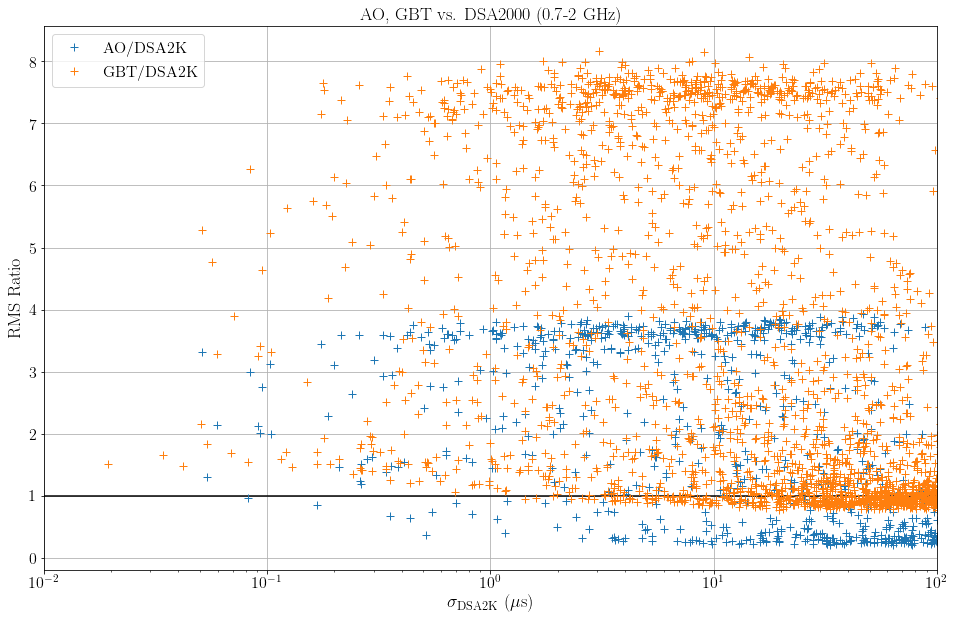

In [83]:
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'lines.markersize': 8})
ax.set_xlabel(r'$\sigma_\mathrm{DSA2K}\ (\mathrm{\mu s})$')
ax.set_ylabel('RMS Ratio')
ax.set_title(r'AO, GBT vs. DSA2000 (0.7-2 GHz)')
ax.set_xscale('log')
ax.set_xlim(1e-2, 100)
#ax.set_ylim(0, 2)
ax.axhline(1., color='black')
ax.plot(dsa_ao_stoas, aodsaratio, '+', label='AO/DSA2K')
ax.plot(dsa_gb_stoas, gbdsaratio, '+', label='GBT/DSA2K')
ax.legend(loc='upper left')
ax.grid()
plt.show();

# Write out .par and ASCII files
Write out a .par file for each pulsar and an ASCII file for each pta.model file

In [84]:
from glob import glob

for f in glob('models/*.pta.model'):
    with open(f, 'rb') as checkf:
    checkmod=cPickle.load(checkf)
    print('{} contains {} psrs'.format(f, len(checkmod.population)))
    try:
        mkasc.mkasc(f, sortsigma=True)
    except AttributeError:
        print(f + ' didnt have the thing')
        raise AttributeError

models/excl_AO_430_Lwide_V3.pta.model
models/excl_AO_Lwide_Swide_V3.pta.model
models/excl_GBT_Rcvr800_Rcvr12_V2.pta.model
models/excl_GBT_UWB_V3.pta.model
models/excl_AO_UWB_V1.pta.model
models/excl_dsa2k_07-2_V3.pta.model
models/excl_dsa2k_07-2_halfAeff_V3.pta.model
models/excl_dsa2k_07-2_quartAeff_V3.pta.model
models/excl_VLA_LBand-SBand_V2.pta.model
models/excl_ngVLA_Band1-2_V3.pta.model
models/incl_AO_430_Lwide_V3.pta.model
models/incl_AO_Lwide_Swide_V3.pta.model
models/incl_GBT_Rcvr800_Rcvr12_V2.pta.model
models/incl_GBT_UWB_V3.pta.model
models/incl_AO_UWB_V1.pta.model
models/incl_dsa2k_07-2_V3.pta.model
models/incl_dsa2k_07-2_halfAeff_V3.pta.model
models/incl_dsa2k_07-2_quartAeff_V3.pta.model
models/incl_VLA_LBand-SBand_V2.pta.model
models/incl_ngVLA_Band1-2_V3.pta.model


In [ ]:
!git rm -r ./data/exclude/PAR/*
!git rm -r ./data/include/PAR/*

In [99]:
!mkdir ./data/exclude/PAR/
!mkdir ./data/include/PAR/

mkdir: cannot create directory ‘./data/exclude/PAR/’: File exists
mkdir: cannot create directory ‘./data/include/PAR/’: File exists


In [100]:
# write out exclude par files
with open('models/excl_MSPpop.model', 'rb') as exclf:
    exclmod = cPickle.load(exclf)
for p in exclmod.population:
    with open('data/exclude/PAR/{}.par'.format(p.jname()), 'wb') as parf:
        parf.write(p.parfile())

In [101]:
# write out included par files
with open('models/incl_MSPpop.model', 'rb') as inclf:
    inclmod = cPickle.load(inclf)
for p in inclmod.population:
    with open('data/include/PAR/{}.par'.format(p.jname()), 'wb') as parf:
        parf.write(p.parfile())

# Write out master ASCII files

In [104]:
# Read in all model files

# Arecibo 430 & Lwide PTA
with open('models/incl_AO_430_Lwide_V3.pta.model', 'rb') as aoinf:
    ao430L_pta = cPickle.load(aoinf)

# Arecibo L & S-band
with open('models/incl_AO_Lwide_Swide_V3.pta.model', 'rb') as aoinf:
    aoLS_pta = cPickle.load(aoinf)

# GBT PTA
with open('models/incl_GBT_Rcvr800_Rcvr12_V2.pta.model', 'rb') as gbinf:        
    gbt_pta = cPickle.load(gbinf)

# GBT UWB (double integration time for wide-band)
with open('models/incl_GBT_UWB_V3.pta.model', 'rb') as guwbinf:   
     gbtuwb_pta = cPickle.load(guwbinf)

# AO UWB
with open('models/incl_AO_UWB_V1.pta.model', 'rb') as auwbinf:   
     aouwb_pta = cPickle.load(auwbinf)

# DSA 0.7-2 GHz full array
with open('models/incl_dsa2k_07-2_V3.pta.model', 'rb') as dsa072inf:
    dsa072_pta = cPickle.load(dsa072inf)

# DSA 0.7-2, 1/2 Aeff
with open('models/incl_dsa2k_07-2_halfAeff_V3.pta.model', 'rb') as dsahalfinf:
    dsa072half_pta = cPickle.load(dsahalfinf)

# DSA 0.7-2, 1/4 Aeff
with open('models/incl_dsa2k_07-2_quartAeff_V3.pta.model', 'rb') as dsaqtinf:
    dsa072quart_pta = cPickle.load(dsaqtinf)

# VLA L-S band
with open('models/incl_VLA_LBand-SBand_V2.pta.model', 'rb') as vlaLSf:
    vlaLS_pta = cPickle.load(vlaLSf)


# ngVLA Band1-Band2 20% area
with open('models/incl_ngVLA_Band1-2_V3.pta.model', 'rb') as ngvlaf:
    ngvla_pta = cPickle.load(ngvlaf)

In [105]:
# combine Arecibo RMSs into single PTA
aobest_full = []
for psrs in zip(ao430L_pta.population, aoLS_pta.population):
    best1 = sorted(psrs,
                   key=lambda p: (p.sigma_toa < 0, p.sigma_toa))[0]
    aobest_full.append(best1)
aobest_pta = Timed()
aobest_pta.population = aobest_full
if hasattr(aoLS_pta.population, 'rn_lnC2'):
    aobest_pta.rn_lnC2 = aoLS_pta.population.rn_lnC2
    aobest_pta.rn_alpha = aoLS_pta.population.rn_alpha
    aobest_pta.rn_beta = aoLS_pta.population.rn_beta
    aobest_pta.rn_gamma = aoLS_pta.population.rn_gamma
    aobest_pta.rn_delta = aoLS_pta.population.rn_delta

In [107]:
# Sort all PTA pulsar lists on DSA2000 list
dsasort = sorted(enumerate(dsa072_pta.population),
                 key=lambda en: (en[1].sigma_toa < 0., en[1].sigma_toa))
idx = [en[0] for en in dsasort]
ptalist = [aobest_pta, gbt_pta, aouwb_pta, gbtuwb_pta,
            dsa072_pta, dsa072half_pta, dsa072quart_pta, vlaLS_pta, ngvla_pta]
for pta in ptalist:
    pta.population = list(itemgetter(*idx)(pta.population))

In [108]:
# write out total RMSs to single file
with open('data/include/tot_sigTOA_allinstr.pta.asc', 'wb') as f:
    headstr = "# Name\tAO\tGBT\tAO_UWB\tGBT_UWB\tDSA2K_full\tDSA2K_half\tDSA2K_qtr\tVLA_LS\tngVLA_Band12"
    if all(pta.rn_lnC2 is not None for pta in ptalist):
        headstr = "\t".join([headstr, 'rn_amp\trn_index'])
    headstr = "".join([headstr, "\n"])
    f.write(headstr)
    for psrs in zip(aobest_pta.population, gbt_pta.population,
                     aouwb_pta.population, gbtuwb_pta.population,
                     dsa072_pta.population, dsa072half_pta.population,
                     dsa072quart_pta.population, vlaLS_pta.population,
                     ngvla_pta.population):
        s = "{0}".format(psrs[0].jname())
        for p in psrs:
            s = "\t".join([s, "{0}".format(p.sigma_toa)])
        if psrs[0].rn_amp is not None:
            s = "\t".join([s, "{ared}\t{gamred}".format(ared=psrs[0].rn_amp,
                                                        gamred=psrs[0].rn_index)])
        s = "".join([s, "\n"])
        f.write(s)